In [13]:
import glob
import rasterio
from rasterio import features
import numpy as np
import xarray as xr
import rioxarray as rxr

import geopandas as gpd
import matplotlib.pyplot as plt

# import utils

Link: https://sis.agr.gc.ca/cansis/nsdb/slc/v3.2/index.html

In [47]:
soils_path = "/Users/kyla/Downloads/ca_all_slc_v3r2/ca_all_slc_v3r2.shp"
sample_ds_path = "sample_format.tif"

In [51]:
ds = rxr.open_rasterio(sample_ds_path)
ds

<xarray.DataArray (band: 1, y: 854, x: 1422)>
[1214388 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -115.0 -115.0 -115.0 ... -105.0 -105.0 -105.0
  * y            (y) float64 56.0 55.99 55.98 55.98 ... 50.02 50.01 50.01 50.0
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    long_name:      2 metre temperature
    units:          K
    scale_factor:   1.0
    add_offset:     0.0

In [52]:
max_lon, min_lon, max_lat, min_lat = (
    np.max(ds.x.values),
    np.min(ds.x.values),
    np.max(ds.y.values),
    np.min(ds.y.values),
)

In [53]:
gdf = gpd.read_file(soils_path, bbox=(min_lon, min_lat, max_lon, max_lat))
gdf

,AREA,PERIMETER,POLY_ID,ECO_ID,geometry
0,0.065418,4.355641,347025,347,"POLYGON ((-106.13587 56.53449, -106.12938 56.5..."
1,0.512950,8.403849,607015,607,"POLYGON ((-113.72411 56.57883, -113.72693 56.5..."
2,0.240309,4.271803,354003,354,"POLYGON ((-107.48533 56.46050, -107.48306 56.4..."
3,0.210337,3.568273,607016,607,"POLYGON ((-112.81725 56.47001, -112.81627 56.4..."
4,0.299331,5.113838,347026,347,"POLYGON ((-106.40586 56.42669, -106.40066 56.4..."
...,...,...,...,...,...
1106,0.003177,0.318275,816020,816,"POLYGON ((-105.82374 49.98162, -105.82261 49.9..."
1107,0.008437,0.461942,829005,829,"POLYGON ((-111.59847 50.01946, -111.59877 50.0..."
1108,0.023275,1.496144,825012,825,"POLYGON ((-107.39807 49.99807, -107.39975 49.9..."
1109,0.044989,1.442305,821009,821,"POLYGON ((-109.91358 50.00109, -109.91338 50.0..."


In [54]:
gdf = gdf.dissolve("ECO_ID").reset_index()
gdf

,ECO_ID,geometry,AREA,PERIMETER,POLY_ID
0,347,"POLYGON ((-105.53658 55.25851, -105.55436 55.2...",0.065418,4.355641,347025
1,353,"POLYGON ((-104.07106 55.39080, -104.03885 55.3...",0.108869,2.535749,353008
2,354,"POLYGON ((-105.60940 55.54520, -105.60264 55.5...",0.240309,4.271803,354003
3,607,"POLYGON ((-113.38650 55.91994, -113.38326 55.9...",0.512950,8.403849,607015
4,609,"POLYGON ((-112.58291 55.49258, -112.56135 55.4...",0.071859,7.270060,609001
...,...,...,...,...,...
152,1017,"POLYGON ((-114.84670 49.88574, -114.83939 49.8...",0.102281,2.975180,1017024
153,1018,"POLYGON ((-114.14929 50.11007, -114.14859 50.1...",0.095998,2.515288,1018005
154,9609,"POLYGON ((-111.75040 55.09390, -111.73839 55.0...",0.049116,1.305630,9609001
155,9687,"POLYGON ((-111.95540 53.80763, -111.96202 53.8...",0.031676,0.872767,9687010


In [55]:
gdf[gdf.ECO_ID.isna()]

,ECO_ID,geometry,AREA,PERIMETER,POLY_ID


In [56]:
sorted(gdf["ECO_ID"].unique())[:5]

[347, 353, 354, 607, 609]

In [63]:
# copy and update the metadata from the input raster for the output
rst = rasterio.open(sample_ds_path)
meta = rst.meta.copy()
meta.update(dtype="int16", compress="lzw", driver="GTiff", count=1)
# Now burn the features into the raster and write it out

out_fn = "sample.tif"

with rasterio.open(out_fn, "w+", **meta) as out:
    out_arr = out.read(1)

    # this is where we create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf.ECO_ID))

    burned = features.rasterize(
        shapes=shapes, fill=np.nan, out=out_arr, transform=out.transform
    )

    print(np.unique(burned))

    out.write_band(1, burned)

[ 347  353  354  607  609  612  613  614  615  616  617  619  620  622
  623  628  629  630  631  636  637  638  639  640  641  642  643  644
  645  646  647  648  649  650  651  652  653  654  655  656  657  658
  660  661  678  679  680  681  682  683  684  685  686  687  688  689
  690  692  693  695  696  698  699  701  702  703  705  706  708  710
  711  727  728  729  730  731  732  733  734  735  736  737  738  739
  740  741  742  743  744  745  746  750  767  768  769  770  771  772
  773  774  775  776  777  778  779  780  781  782  783  784  785  786
  787  788  789  790  791  792  793  795  798  799  803  804  805  806
  807  808  809  810  811  812  813  814  815  816  817  818  819  820
  821  822  823  824  825  826  827  828  829  995  999 1016 1017 1018
 9609 9687 9787]


In [64]:
ds = rxr.open_rasterio(
    out_fn
)  # utils.load_and_rasterize_shp_like_ds(soils_path, sample_ds_path)
ds

<xarray.DataArray (band: 1, y: 854, x: 1422)>
[1214388 values with dtype=int16]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -115.0 -115.0 -115.0 ... -105.0 -105.0 -105.0
  * y            (y) float64 56.0 55.99 55.98 55.98 ... 50.02 50.01 50.01 50.0
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [65]:
len(np.unique(ds.values))

157

In [ ]:
# "surface_net_solar_radiation"

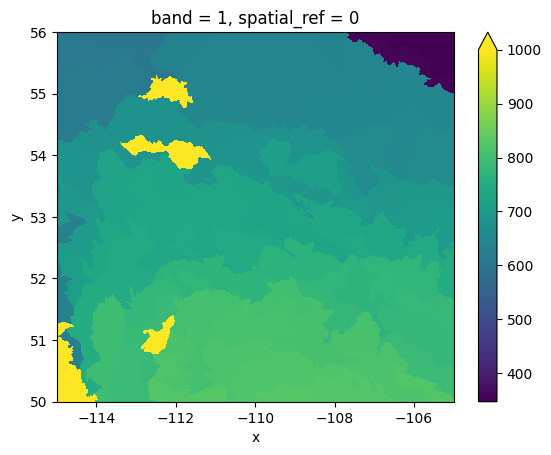

In [73]:
ds.plot(vmax=1000)